In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import scipy
%matplotlib inline

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

In [3]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 64
EPOCHS = 5
SAVE_SAMPLE_PERIOD = 50

In [4]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [5]:
class ConvLayer:
    def __init__(self, filter_size, num_input_channels, num_filters, stride=2, padding='SAME', name=None):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        self.shape = shape
        self.W = new_weights(shape)
        self.b = new_biases(num_filters)
        self.stride = stride
        self.padding = padding
        self.params = [self.W, self.b]
        self.name = name
        
    def forward(self, X):
        X = tf.nn.conv2d(X, self.W, strides=[1, self.stride, self.stride, 1], padding=self.padding)
        return X + self.b

In [6]:
class BatchNormLayer:
    def __init__(self, D, name=None):
        self.mean = tf.Variable(np.zeros(D, dtype=np.float32), trainable=False)
        self.var = tf.Variable(np.ones(D, dtype=np.float32), trainable=False)
        self.gamma = tf.Variable(np.ones(D, dtype=np.float32))
        self.beta = tf.Variable(np.zeros(D, dtype=np.float32))
        self.params = [self.gamma, self.beta]
        self.name = name
    def forward(self, X):
        return tf.nn.batch_normalization(X, self.mean, self.var, self.beta, self.gamma, 1e-3)

In [7]:
class DeConvLayer:
    def __init__(self, filter_size, num_input_channels, num_filters, output_shape, stride=2, padding='SAME', name=None):
        shape = [filter_size, filter_size, num_filters, num_input_channels]
        self.shape = shape
        self.W = new_weights(shape)
        self.b = new_biases(num_filters)
        self.stride = stride
        self.padding = padding
        self.output_shape = output_shape
        self.params = [self.W, self.b]
        self.name = name
        
    def forward(self, X):
        X = tf.nn.conv2d_transpose(X, self.W, self.output_shape, 
                                   strides=[1, self.stride, self.stride, 1], padding=self.padding)
        return X + self.b

In [8]:
class DenseLayer:
    def __init__(self, input_size, output_size, name=None):
        self.W = new_weights([input_size, output_size])
        self.b = new_biases(output_size)
        self.params = [self.W, self.b]
        self.name = name
        
    def forward(self, X):
        return tf.matmul(X, self.W) + self.b

In [9]:
class ReLUlayer:
    def __init__(self, name=None):
        self.params = []
        self.name = name
    def forward(self, X):
        return tf.nn.relu(X)

In [10]:
class LeakyReLUlayer:
    def __init__(self, name=None):
        self.params = []
        self.name = name
    def forward(self, X, alpha = 0.2):
        return tf.maximum(alpha*X, X)

In [11]:
class DCGAN:
    def __init__(self, img_length, num_colors, d_config, g_config, session):
        self.w = img_length
        self.h = img_length
        self.c = num_colors
        self.d_params = []
        self.g_params = []
        self.latent_dims = g_config['z']
        # real input
        self.X = tf.placeholder(tf.float32, shape=(None, img_length, img_length, num_colors), name='X')
        # fake input
        self.Z = tf.placeholder(tf.float32, shape=(None, self.latent_dims), name='Z')
        
        self.batch_size = tf.placeholder(tf.int32, shape=(), name='batch_size')
        # build discriminator 
        logits = self.build_discriminator(self.X, d_config)
        # build generator
        self.sample_image = self.build_generator(self.Z, g_config)
        
#         with tf.variable_scope("discriminator") as scope:
#             scope.reuse_variables()
        sample_logits = self.d_forward(self.sample_image)
        
#             with tf.variable_scope('generator') as scope:
#                 scope.reuse_variables()
        self.sample_images_test = self.g_forward(self.Z)
            
        # discriminator costs
        self.d_cost_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.ones_like(logits))
        self.d_cost_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=sample_logits, labels=tf.zeros_like(sample_logits))
        self.d_cost = tf.reduce_mean(self.d_cost_real) + tf.reduce_mean(self.d_cost_fake)
        # generator costs
        self.g_cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=sample_logits, labels=tf.ones_like(sample_logits))
        )
        
        # optimizer
        self.get_d_params()
        self.get_g_params()
        self.d_train_op = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA1).minimize(self.d_cost, var_list=self.d_params)
        self.g_train_op = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA1).minimize(self.g_cost, var_list=self.g_params)
        
        self.init_op = tf.global_variables_initializer()
        self.sess = session
        self.sess.run(self.init_op)
    
    def build_discriminator(self, X, d_config):
        with tf.variable_scope('discriminator') as scope:
            w, h = self.w, self.h
            self.d_conv_layers = []
            num_input_channels = self.c
            count = 1
            # build conv layers
            for filter_size, num_filters, stride, batch_norm in d_config['conv_layers']:
                name = 'dconv_' + str(count)
                self.d_conv_layers.append(ConvLayer(filter_size, num_input_channels, num_filters, stride, name=name))
                w /= stride
                h /= stride
                if batch_norm:
                    name = 'dbatchnorm_'+ str(count)
                    self.d_conv_layers.append(BatchNormLayer(num_filters, name=name))

                name = 'drelu_'+ str(count)    
                self.d_conv_layers.append(LeakyReLUlayer(name=name))

                num_input_channels = num_filters
                count += 1

            # build dense layers
            self.d_dense_layers = []
            input_size = int(w * h * num_input_channels)
            for output_size, batch_norm in d_config['dense_layers']:
                name = 'ddense_' + str(count)
                self.d_dense_layers.append(DenseLayer(input_size, output_size, name=name))

                if batch_norm:
                    name = 'dbatchnorm_'+ str(count)
                    self.d_dense_layers.append(BatchNormLayer(output_size, name=name))

                name = 'drelu_'+ str(count)
                self.d_dense_layers.append(LeakyReLUlayer(name=name))  

                input_size = output_size
                count += 1

            self.final_dense_layer = DenseLayer(input_size, 1, name='ddense_' + str(count))

            logits = self.d_forward(X)
        
            return logits
        
    def get_d_params(self):
        for layer in self.d_conv_layers:
            self.d_params += layer.params
        
        for layer in self.d_dense_layers:
            self.d_params += layer.params
        
        self.d_params += self.final_dense_layer.params
        
    def d_forward(self, X):
        for layer in self.d_conv_layers:
            X = layer.forward(X)
            
        X = tf.layers.flatten(X)
        for layer in self.d_dense_layers:
            X = layer.forward(X)
            
        logits = self.final_dense_layer.forward(X)
        return logits
                
    def build_generator(self, Z, g_config):
        with tf.variable_scope('generator') as scope:
            self.g_dense_layers = []
            count = 1
            input_size = self.latent_dims
            for output_size, batch_norm in g_config['dense_layers']:
                name = 'gdense_' + str(count)
                self.g_dense_layers.append(DenseLayer(input_size, output_size, name=name))

                if batch_norm:
                    name = 'gbatchnorm_'+ str(count)
                    self.g_dense_layers.append(BatchNormLayer(output_size, name=name))

                name = 'grelu_'+ str(count)
                self.g_dense_layers.append(ReLUlayer(name=name))  

                input_size = output_size
                count += 1
                
            
            self.g_conv_layers = []
            self.dims = [self.w]
            dim = self.w
            for _, _, stride, _ in reversed(g_config['conv_layers'][1:]):
                dim = dim // stride
                self.dims.append(dim)
                
            num_input_channels = input_size // g_config['projection_dim']**2
            for filter_size, num_filters, stride, batch_norm in g_config['conv_layers'][:-1]:
                name = 'gconv_' + str(count)
                dim = self.dims.pop()
                output_shape = [self.batch_size, dim, dim, num_filters]
                self.g_conv_layers.append(DeConvLayer(filter_size, num_input_channels, num_filters,
                                                      output_shape, stride, name=name))

                if batch_norm:
                    name = 'gbatchnorm_'+ str(count)
                    self.g_conv_layers.append(BatchNormLayer(num_filters, name=name))

                name = 'grelu_'+ str(count)    
                self.g_conv_layers.append(ReLUlayer(name=name))

                num_input_channels = num_filters
                count += 1

            dim = self.dims.pop()
            filter_size, num_filters, stride, _ = g_config['conv_layers'][-1]
            output_shape = [self.batch_size, dim, dim, num_filters]
            self.g_final_conv_layer = DeConvLayer(filter_size, num_input_channels, num_filters,
                                                      output_shape, stride, name='gconv_' + str(count))

            return self.g_forward(Z)
    
    def get_g_params(self):
        for layer in self.g_dense_layers:
            self.g_params += layer.params
            
        for layer in self.g_conv_layers:
            self.g_params += layer.params
        
        self.g_params += self.g_final_conv_layer.params
        
        
    def g_forward(self, Z):
        for layer in self.g_dense_layers:
            print(Z.shape)
            Z = layer.forward(Z)
        
        projection_dim = g_config['projection_dim']
        Z = tf.reshape(Z, [-1, projection_dim, projection_dim, Z.shape[1].value//projection_dim**2])
        for layer in self.g_conv_layers:
            print(Z.shape)
            Z = layer.forward(Z)
        
        Z = self.g_final_conv_layer.forward(Z)
        print(Z.shape)
        Z = tf.nn.tanh(Z)
        return Z
        
    
    def samples(self, n):
        Z = np.random.uniform(-1, 1, size=(n, self.latent_dims))
        samples = self.sess.run(self.sample_images_test, feed_dict={self.Z:Z, self.batch_size:n})
        return samples
    
    def fit(self, X):
        d_costs, g_costs = [], []
        N = len(X)
        n_batches = N // BATCH_SIZE
        total_iters = 0
        for i in range(EPOCHS):
            print("Epoch: ", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*BATCH_SIZE: (j+1)*BATCH_SIZE]
            
                Z = np.random.uniform(-1, 1, size=(BATCH_SIZE, self.latent_dims))

                _, d_cost = self.sess.run(
                    (self.d_train_op, self.d_cost), feed_dict={self.X : batch, self.Z : Z, self.batch_size : BATCH_SIZE}
                )

                d_costs.append(d_cost)

                _, g_cost1 = self.sess.run(
                    (self.g_train_op, self.g_cost), feed_dict={self.Z : Z, self.batch_size : BATCH_SIZE}
                )

                _, g_cost2 = self.sess.run(
                    (self.g_train_op, self.g_cost), feed_dict={self.Z : Z, self.batch_size : BATCH_SIZE}
                )
                
                g_cost = (g_cost1 + g_cost2)/2
                g_costs.append(g_cost)
                
                if j % 100 == 0:
                    print("iter: %d, generator_cost: %.3f, discriminator_cost: %.3f" % (j, g_cost, d_cost))
                
                total_iters += 1
                
                if total_iters % SAVE_SAMPLE_PERIOD == 0:
                    print("saving a sample")
                    samples = self.samples(64)
                    d = self.w
                    
                    if samples.shape[-1] == 1:
                        samples = samples.reshape(64, d, d)
                        flat_image = np.empty((8*d, 8*d))
                        
                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k].reshape(d, d)
                                k += 1
                    else:
                        flat_image = np.empty((8*d, 8*d, 3))
                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k]
                                k += 1
                        
                    
                    scipy.misc.imsave('./images/DCGAN/samples/samples_at_iter_%d.png' % total_iters, flat_image)
                
        plt.clf()
        plt.plot(d_costs, label='discriminator cost')
        plt.plot(g_costs, label='generator cost')
        plt.legend()
        plt.show()

In [ ]:
from keras.datasets import mnist
(X, _), (_, _) = mnist.load_data()
X = X.astype('float32')
X /= 255
X = X.reshape(len(X), 28, 28, 1)
dim = X.shape[1]
colors = X.shape[-1]

d_config = {'conv_layers':[(3, 64, 1, False), (3, 32, 2, True), (3, 16, 2, True)], 
           'dense_layers':[(256, True), (128, True)]}

g_config = {'z':100, 
           'conv_layers': [(3, 32, 1, True), (3, 64, 1, True), (3, 128, 2, True), (3, colors, 2, False)], 
           'dense_layers': [(980, True)]}

In [ ]:
gan = DCGAN(dim, colors, d_config, g_config, sess)

In [ ]:
gan.fit(X)

In [12]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import glob

In [14]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    h, w, c = img.shape
    edge_h = int(round(h - 108) / 2.0)
    edge_w = int(round(w - 108) / 2.0)
    img = img[edge_h:edge_h + 128, edge_w:edge_w + 128]
    img = scipy.misc.imresize(img, (64, 64))
    img = img.astype('float32')
    img = (img / 255) * 2.0 - 1.0
    return img

In [15]:
i = 0
img_list = []
for path in glob.glob('./images/DCGAN/img_align_celeba/*.jpg'):
    img = preprocess_image(path)
    img_list.append(img)
    i += 1
    if i == 60000:
        break

C:\Users\Owner\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


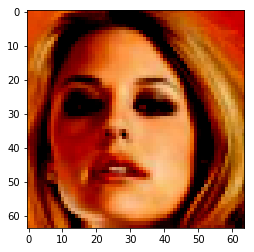

In [16]:
plt.imshow(img_list[23])

In [17]:
X = np.array(img_list)
X = X.reshape(len(X), X.shape[2], X.shape[2], X.shape[-1])
dim = X.shape[1]
colors = X.shape[-1]

In [18]:
d_config = {'conv_layers':[(5, 64, 2, False), (5, 128, 2, True), (5, 256, 2, True), (5, 512, 2, True)], 
           'dense_layers':[]}

g_config = {'z':100, 
           'conv_layers': [(5, 256, 2, True), (5, 128, 2, True), (5, 64, 2, True), (5, colors, 2, False)], 
           'dense_layers': [(512, True)],
           'projection_dim': 4}

In [19]:
gan = DCGAN(dim, colors, d_config, g_config, sess)

(?, 100)
(?, 512)
(?, 512)
(?, 4, 4, 32)
(?, 8, 8, 256)
(?, 8, 8, 256)
(?, 8, 8, 256)
(?, 16, 16, 128)
(?, 16, 16, 128)
(?, 16, 16, 128)
(?, 32, 32, 64)
(?, 32, 32, 64)
(?, 64, 64, 3)
(?, 100)
(?, 512)
(?, 512)
(?, 4, 4, 32)
(?, 8, 8, 256)
(?, 8, 8, 256)
(?, 8, 8, 256)
(?, 16, 16, 128)
(?, 16, 16, 128)
(?, 16, 16, 128)
(?, 32, 32, 64)
(?, 32, 32, 64)
(?, 64, 64, 3)
